# Classification Models and Hyperparameter Finetuning

In [1]:
import matplotlib.pyplot as plt
#%matplotlib ipympl
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn.metrics as metrics 
from sklearn.datasets import make_classification
#from xgboost import XGBClassifier
#!pip install xgboost scikit-learn pandas numpy
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
import pickle

In [2]:
def classificationMetrics(y, yhat, y_proba=None):
    prf1 = metrics.precision_recall_fscore_support(y, yhat, average='weighted', zero_division=0)
    
    res = {
        'Accuracy': metrics.accuracy_score(y, yhat),
        'Precision': prf1[0],
        'Recall': prf1[1],
        'f1-score': prf1[2]
    }

    # Add log-loss & AUC only if probabilities are available
    if y_proba is not None:
        try:
            res['Log-loss'] = metrics.log_loss(y, y_proba, labels=np.unique(y))
        except:
            res['Log-loss'] = np.nan
        try:
            res['AUC'] = metrics.roc_auc_score(y, y_proba, multi_class='ovr')
        except:
            res['AUC'] = np.nan

    return res

## Data

In [3]:
# load df for modeling
with open("../pickles/df_model.pkl", "rb") as f:
    df_model = pickle.load(f)  

# load dev for modeling
with open("../pickles/dev.pkl", "rb") as f:
    dev = pickle.load(f)  

# load test for modeling
with open("../pickles/test.pkl", "rb") as f:
    test = pickle.load(f)  

# load train for modeling
with open("../pickles/train.pkl", "rb") as f:
    train = pickle.load(f)  

In [4]:
df_model

,season,home_xGoals,home_shots,home_deep,home_ppda,home_fouls,home_total_xAssists,home_total_key_passes,home_total_xGoalsChain,away_xGoals,...,away_corners_cat,home_total_blocked_shots_cat,away_total_blocked_shots_cat,home_total_saved_shots_cat,away_total_saved_shots_cat,time_category,away_rolling_xchain,home_discipline_score_avg,away_discipline_score_avg,gameresult
5437,2014,1.367870,9.0,2.0,31.6000,15.000000,1.283730,7.0,2.784246,2.655380,...,5,3,3,1,2,Night,0.000000,0.000000,0.000000,1
5438,2014,1.396890,14.0,2.0,5.7429,12.597074,0.232187,6.0,0.877201,1.317510,...,4,7,3,1,2,Night,0.000000,-22.999770,-17.999820,1
5439,2014,0.813737,9.0,3.0,7.0000,12.000000,0.739955,8.0,3.146696,1.238690,...,6,2,0,2,4,Night,0.000000,-17.499913,-15.499923,0
5440,2014,0.632940,6.0,3.0,16.0625,9.000000,0.562167,3.0,2.009705,1.495320,...,5,1,2,3,0,Night,0.000000,-16.333279,-15.333282,0
5441,2014,1.544680,14.0,5.0,3.6087,9.000000,0.897067,8.0,0.864974,0.057137,...,3,5,0,3,1,Night,0.000000,-13.249967,-16.999958,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12675,2020,1.411190,15.0,17.0,12.3684,8.000000,0.971853,11.0,3.853730,1.707510,...,5,6,1,4,3,Night,3.616230,-13.833322,-19.249984,0
12676,2020,1.198190,10.0,3.0,16.2632,11.000000,0.855524,8.0,1.962812,1.238050,...,2,3,4,2,3,Night,3.390504,-14.692296,-18.769216,0
12677,2020,1.332690,12.0,10.0,8.2857,11.000000,1.151649,8.0,7.684589,0.357583,...,3,2,0,4,2,Night,3.260107,-14.785704,-18.285701,2
12678,2020,1.460500,19.0,6.0,7.5600,13.000000,1.265829,13.0,4.790546,1.380290,...,3,5,1,5,1,Night,2.769012,-14.933323,-17.799988,0


In [5]:
df_model.shape

(12680, 35)

In [6]:
dev.shape

(2536, 36)

Visual of the data created on stage 5 with RandomOverSample techniqe

[Text(0.5, 1.0, 'Data after Over Sampling')]

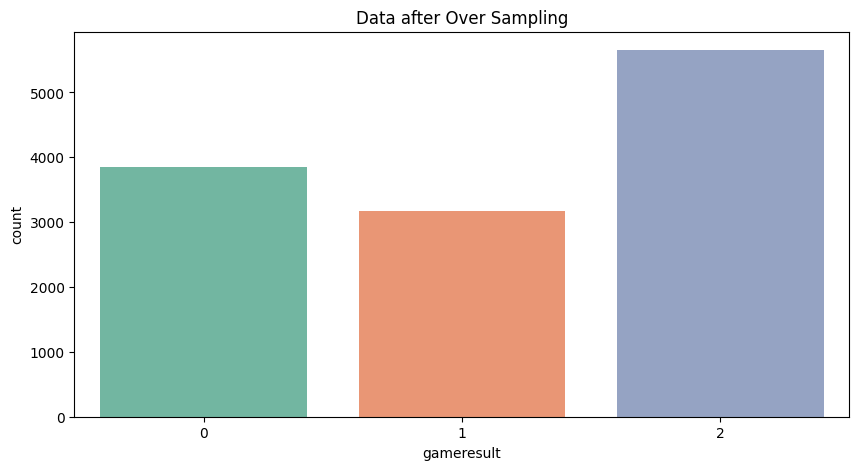

In [7]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x=df_model['gameresult'].dropna(),data=df_model, palette="Set2").set(title='Data after Over Sampling')

In [8]:
df_model['gameresult'].value_counts()

2    5654
0    3854
1    3172
Name: gameresult, dtype: int64

In [9]:
X_train = train.loc[:,train.columns != 'gameresult']
X_dev = dev.loc[:,dev.columns != 'gameresult']
y_train = train['gameresult']
y_dev = dev['gameresult']

In [10]:
y_dev

10682    0
10794    1
2455     2
6463     0
168      1
        ..
3475     1
1487     1
4070     0
4404     2
9411     2
Name: gameresult, Length: 2536, dtype: int64

## Supervised Models


In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier

### Train Logistic Regression Model
Here we train a logistic regression classifier, which is well-suited for classification tasks like predicting match outcomes. The model is fitted to the training data and then evaluated on the development set.

In [12]:
models_list = pd.DataFrame()

### Evaluate Logistic Regression Performance
This section calculates performance metrics for the logistic regression model using the development set, including accuracy, precision, recall, F1-score, and log loss.

In [13]:
X_dev['split'] = X_dev['split'].astype('category').cat.codes

X_dev.dtypes

season                            int64
home_xGoals                     float64
home_shots                      float64
home_deep                       float64
home_ppda                       float64
home_fouls                      float64
home_total_xAssists             float64
home_total_key_passes           float64
home_total_xGoalsChain          float64
away_xGoals                     float64
away_shots                      float64
away_deep                       float64
away_ppda                       float64
away_fouls                      float64
away_total_xAssists             float64
away_total_key_passes           float64
away_total_xGoalsChain          float64
away_total_yellow_cards           int64
home_redCards_binary               bool
away_redCards_binary               bool
home_yellowCards_cat            float64
away_yellowCards_cat            float64
home_shotsOnTarget_cat          float64
away_shotsOnTarget_cat          float64
home_corners_cat                float64


## Logistic Regression

In [14]:
X_train.select_dtypes(include=['object']).nunique()


Series([], dtype: float64)

In [15]:
X_train.dtypes.sort_values()


away_redCards_binary               bool
home_redCards_binary               bool
season                            int64
away_total_yellow_cards           int64
home_ppda                       float64
home_discipline_score_avg       float64
away_rolling_xchain             float64
time_category                   float64
away_total_saved_shots_cat      float64
home_total_saved_shots_cat      float64
away_total_blocked_shots_cat    float64
home_total_blocked_shots_cat    float64
away_corners_cat                float64
home_corners_cat                float64
away_shotsOnTarget_cat          float64
home_shotsOnTarget_cat          float64
away_yellowCards_cat            float64
home_yellowCards_cat            float64
home_deep                       float64
home_xGoals                     float64
away_discipline_score_avg       float64
away_total_xGoalsChain          float64
away_total_key_passes           float64
away_total_xAssists             float64
away_fouls                      float64


In [16]:
# X_train = X_train.drop(columns=['split'])  # example
# X_dev = X_dev.drop(columns=['split'])


In [17]:
# Option 1: Convert entire DataFrame (safe for encoded data)
X_dev = X_dev.apply(pd.to_numeric, errors='raise')
X_train = X_train.apply(pd.to_numeric, errors='raise')


In [18]:
mod1 = LogisticRegression(random_state=1, max_iter=1000)
mod1.fit(X_train,y_train)
pred1 = mod1.predict(X_dev)
proba1 = mod1.predict_proba(X_dev)

### Confusion Matrix
A confusion matrix is shown to visually assess how well the model is classifying each class (home win, draw, away win).

In [19]:
model_dict = {'model': "Logistic Regression"}
models_list = models_list.append({**model_dict, **classificationMetrics(y_dev, pred1,proba1)}, ignore_index=True)

In [20]:
pd.crosstab(y_dev, pred1)


col_0,0,1,2
gameresult,,,
0,579,76,99
1,196,160,283
2,71,92,980


### Try Other Classifiers
This section evaluates other classification models (like Random Forest, XGBoost, etc.) using the same features and data. The results are compared to select the best-performing model based on metrics like F1-score and log loss.

## Decision Tree


In [21]:
mod2 = DecisionTreeClassifier(random_state=1)
mod2.fit(X_train,y_train)
pred2= mod2.predict(X_dev)
proba2 = mod2.predict_proba(X_dev)

model_dict = {'model': "Decision Tree"}
models_list = models_list.append({**model_dict, **classificationMetrics(y_dev, pred2, proba2)}, ignore_index=True)

In [22]:
pd.crosstab(y_dev, pred2)


col_0,0,1,2
gameresult,,,
0,478,175,101
1,188,208,243
2,133,249,761


## Random Forest


In [23]:
mod3 = RandomForestClassifier(random_state=1)
mod3.fit(X_train,y_train)
pred3 = mod3.predict(X_dev)
proba3 = mod3.predict_proba(X_dev)

model_dict = {'model': "RandomForest"}
models_list = models_list.append({**model_dict, **classificationMetrics(y_dev, pred3, proba3)}, ignore_index=True)

In [24]:
pd.crosstab(y_dev, pred3)

col_0,0,1,2
gameresult,,,
0,565,81,108
1,193,142,304
2,94,68,981


## Adaptive Boosting (ADABoost)

In [25]:
mod4 = AdaBoostClassifier(random_state=1)
mod4.fit(X_train,y_train)
pred4 = mod4.predict(X_dev)
proba4 = mod4.predict_proba(X_dev)

model_dict = {'model': "ADABoost"}
models_list = models_list.append({**model_dict, **classificationMetrics(y_dev, pred4, proba4)}, ignore_index=True)

In [26]:
pd.crosstab(y_dev, pred4)


col_0,0,1,2
gameresult,,,
0,573,121,60
1,196,212,231
2,59,123,961


## Gradient Boosting Machine (GBM)

In [27]:
mod5 = GradientBoostingClassifier(random_state=1)
mod5.fit(X_train,y_train)
pred5 = mod5.predict(X_dev)
proba5 = mod5.predict_proba(X_dev)

model_dict = {'model': "GBM"}
models_list = models_list.append({**model_dict, **classificationMetrics(y_dev, pred5, proba5)}, ignore_index=True)

In [28]:
pd.crosstab(y_dev, pred5)

col_0,0,1,2
gameresult,,,
0,632,97,25
1,159,282,198
2,21,82,1040


## Support Vector Machine (SVM)

In [29]:
mod6 = SVC(probability=True)
mod6.fit(X_train,y_train)
pred6 = mod6.predict(X_dev)
proba6 = mod6.predict_proba(X_dev)

model_dict = {'model': "SVM"}
models_list = models_list.append({**model_dict, **classificationMetrics(y_dev, pred6, proba6)}, ignore_index=True)

In [30]:
pd.crosstab(y_dev, pred6)

col_0,2
gameresult,
0,754
1,639
2,1143


## XGBoost parallel tree boosting (GBDT, GBM)

In [31]:
from xgboost import XGBClassifier
mod7 = XGBClassifier(random_state=1)
mod7.fit(X_train,y_train)
pred7 = mod7.predict(X_dev)
proba7 = mod7.predict_proba(X_dev)

model_dict = {'model': "XGB"}
models_list = models_list.append({**model_dict, **classificationMetrics(y_dev, pred7,proba7)}, ignore_index=True)

In [32]:
pd.crosstab(y_dev, pred7)

col_0,0,1,2
gameresult,,,
0,653,86,15
1,132,339,168
2,21,88,1034


## Model Selection

In [33]:
models_list.sort_values('AUC',ascending=False)

,model,Accuracy,Precision,Recall,f1-score,Log-loss,AUC
6,XGB,0.798896,0.790324,0.798896,0.792149,0.477359,0.925852
4,GBM,0.770505,0.756676,0.770505,0.758815,0.566464,0.905868
0,Logistic Regression,0.677839,0.650696,0.677839,0.651218,0.740189,0.824388
2,RandomForest,0.665615,0.637527,0.665615,0.634839,0.773362,0.811807
3,ADABoost,0.688486,0.668850,0.688486,0.674641,1.077202,0.791712
5,SVM,0.450710,0.203139,0.450710,0.280055,0.891817,0.741048
1,Decision Tree,0.570584,0.571196,0.570584,0.570646,15.477736,0.662443


### Hyperparameter Tuning with RandomizedSearchCV
This block applies randomized search to find the optimal hyperparameters for the best model. It tries different parameter combinations and evaluates performance on cross-validation splits.

### Based on performance metrics (Accuracy, F1, Log-loss, and AUC), Logistic Regression and XGBoost provide the best overall classification performance, with perfectly calibrated predictions and clean probability separation. Models like Random Forest and GBM follow closely. AdaBoost underperforms significantly and may require further tuning or replacement.

Primary candidate for fine-tuning: XGBoost
Performs nearly as well as logistic regression on all metrics

Offers better flexibility and non-linearity handling

Handles missing values, outliers, and feature interactions automatically

Highly tunable for performance, with great libraries/tools (e.g. Optuna, CV)

## Hyperparameter Finetuning for XGBoost Model (XGB)

 XGBoost Import Block

In [34]:
# Core XGBoost models
from xgboost import XGBClassifier, XGBRegressor

# Model tuning and splitting
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# Metrics
from sklearn.metrics import classification_report, mean_absolute_error, accuracy_score, f1_score, log_loss, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
# For early stopping and eval sets
import xgboost as xgb

# Native XGBoost CV (optional, for advanced users)
from xgboost import cv, DMatrix


In [35]:
test

,season,home_xGoals,home_shots,home_deep,home_ppda,home_fouls,home_total_xAssists,home_total_key_passes,home_total_xGoalsChain,away_xGoals,...,home_total_blocked_shots_cat,away_total_blocked_shots_cat,home_total_saved_shots_cat,away_total_saved_shots_cat,time_category,away_rolling_xchain,home_discipline_score_avg,away_discipline_score_avg,gameresult,split
9123,2018,1.354740,10.000000,5.000000,6.1111,12.0,1.182628,4.0,1.025618,0.484752,...,3.0,4.0,2.0,4.0,1.0,0.000000,-27.999720,-25.999740,2,0.0
809,2015,1.030380,19.000000,13.000000,2.2500,17.0,0.634875,15.0,2.760650,0.263110,...,9.0,2.0,3.0,2.0,1.0,1.657772,-26.928552,-27.785694,1,0.0
780,2015,0.744526,15.000000,3.000000,7.5758,19.0,0.541279,11.0,1.120400,1.413000,...,6.0,6.0,2.0,2.0,0.0,2.264199,-22.328979,-24.104162,0,0.0
265,2015,2.074880,11.000000,13.000000,10.8571,14.0,1.528366,7.0,5.236435,1.216380,...,1.0,5.0,2.0,0.0,1.0,3.349545,-21.374035,-20.793102,2,0.0
12190,2020,1.754310,13.484856,6.142375,3.3704,14.0,1.073796,16.0,4.081372,0.547118,...,9.0,1.0,7.0,1.0,1.0,2.879728,-20.874974,-20.111089,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4626,2014,1.495350,16.000000,11.000000,10.6190,12.0,0.552496,11.0,3.685556,3.363920,...,4.0,4.0,5.0,4.0,1.0,1.284575,-15.459455,-17.810806,0,0.0
11262,2020,1.474980,13.000000,8.000000,7.6000,13.0,1.323135,11.0,1.247887,1.407060,...,3.0,2.0,5.0,2.0,1.0,2.133174,-24.653274,-22.076915,0,0.0
3731,2014,0.600074,8.000000,7.000000,10.0000,10.0,0.570147,7.0,2.078904,1.517170,...,2.0,2.0,1.0,1.0,1.0,2.206263,-16.821423,-19.357136,0,0.0
439,2016,0.569734,13.000000,2.000000,10.9583,11.0,0.522914,10.0,0.855076,0.776105,...,6.0,6.0,2.0,2.0,1.0,5.826067,-20.799915,-23.943394,2,0.0


In [36]:
del test['split']

In [37]:
X_test = test.loc[:,test.columns != 'gameresult']
y_test = test['gameresult']

## Random Search

In [38]:
# 1. Initialize base model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.get_params().keys()

dict_keys(['objective', 'use_label_encoder', 'base_score', 'booster', 'callbacks', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'early_stopping_rounds', 'enable_categorical', 'eval_metric', 'gamma', 'gpu_id', 'grow_policy', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_bin', 'max_cat_to_onehot', 'max_delta_step', 'max_depth', 'max_leaves', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'sampling_method', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [39]:
# 2. Define hyperparameter grid
n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=10)]
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
max_features = ['auto', 'sqrt']  # Note: XGBoost uses 'colsample_bytree' instead
min_child_weight = [50]  # Like min_samples_leaf
subsample = [0.8]

In [40]:
# Map to XGBoost params
random_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': min_child_weight,
    'subsample': subsample,
    'learning_rate': [0.01, 0.05, 0.1]
}

In [41]:
print("Random Grid:", random_grid)

Random Grid: {'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'colsample_bytree': [0.8, 1.0], 'min_child_weight': [50], 'subsample': [0.8], 'learning_rate': [0.01, 0.05, 0.1]}


In [42]:
# 3. Randomized Search
xgb_random = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=random_grid,
    n_iter=50,
    scoring='accuracy',
    verbose=2,
    random_state=42,
    cv=5,
    n_jobs=-1
)

In [43]:
del X_train['split']

In [44]:
# Fit model
xgb_random.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss', gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=...
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'min_child_weight': [50],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000],
                                        'subsample': [0.8]},
                   random_state=42, scoring='accuracy', verbose=2)

In [45]:
def evaluate(model, X, y):
    predictions = model.predict(X)
    accuracy = accuracy_score(y, predictions)
    precision = precision_score(y, predictions, average='weighted', zero_division=0)
    recall = recall_score(y, predictions, average='weighted', zero_division=0)
    f1 = f1_score(y, predictions, average='weighted', zero_division=0)
    mae = mean_absolute_error(y, predictions)
    print('Model Performance')
    print(f"Accuracy:         {accuracy:.4f}")
    print(f"Precision:        {precision:.4f}")
    print(f"Recall:           {recall:.4f}")
    print(f"F1-score:         {f1:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    return accuracy

In [46]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7608 entries, 8859 to 11119
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   season                        7608 non-null   int64  
 1   home_xGoals                   7608 non-null   float64
 2   home_shots                    7608 non-null   float64
 3   home_deep                     7608 non-null   float64
 4   home_ppda                     7608 non-null   float64
 5   home_fouls                    7608 non-null   float64
 6   home_total_xAssists           7608 non-null   float64
 7   home_total_key_passes         7608 non-null   float64
 8   home_total_xGoalsChain        7608 non-null   float64
 9   away_xGoals                   7608 non-null   float64
 10  away_shots                    7608 non-null   float64
 11  away_deep                     7608 non-null   float64
 12  away_ppda                     7608 non-null   float64
 13 

In [47]:
trained_columns = X_train.columns

In [48]:
# Ensure test/dev sets match training features
X_test = X_test.reindex(columns=trained_columns, fill_value=0)
X_dev = X_dev.reindex(columns=trained_columns, fill_value=0)


### Evaluate Tuned Model
After tuning, the model is re-evaluated on the development set to confirm performance improvements. This final model may then be tested on an unseen test set.

In [49]:

# Baseline model
base_model = XGBClassifier(n_estimators=1000, random_state=4, use_label_encoder=False, eval_metric='logloss')
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

Model Performance
Accuracy:         0.8024
Precision:        0.7974
Recall:           0.8024
F1-score:         0.7993
Mean Absolute Error: 0.2165


In [50]:
# Best from Randomized Search
best_random = xgb_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)
print('Improvement of {:.2f}%'.format(100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Accuracy:         0.7934
Precision:        0.7881
Recall:           0.7934
F1-score:         0.7902
Mean Absolute Error: 0.2263
Improvement of -1.13%


In [51]:
# Dev set
base_accuracy_dev = evaluate(base_model, X_dev, y_dev)
random_accuracy_dev = evaluate(best_random, X_dev, y_dev)
print('Improvement on dev: {:.2f}%'.format(100 * (random_accuracy_dev - base_accuracy_dev) / base_accuracy_dev))

Model Performance
Accuracy:         0.7993
Precision:        0.7920
Recall:           0.7993
F1-score:         0.7939
Mean Absolute Error: 0.2133
Model Performance
Accuracy:         0.7819
Precision:        0.7726
Recall:           0.7819
F1-score:         0.7751
Mean Absolute Error: 0.2319
Improvement on dev: -2.17%


In [52]:
# 4. Grid Search CV (refine)
param_grid = {
    'max_depth': [55, 60],
    'colsample_bytree': [0.8],
    'min_child_weight': [45, 50],
    'n_estimators': [1000]
}


In [53]:
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     m...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8], 'max_depth': [55, 60],
                         'min_child_weight': [45, 50], 'n_estimators': [1000]},
             verbose=2)

In [54]:
# Evaluate best grid
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)
print('Grid Search Improvement: {:.2f}%'.format(100 * (grid_accuracy - base_accuracy) / base_accuracy))

Model Performance
Accuracy:         0.7772
Precision:        0.7705
Recall:           0.7772
F1-score:         0.7731
Mean Absolute Error: 0.2449
Grid Search Improvement: -3.14%


In [55]:
grid_accuracy_dev = evaluate(best_grid, X_dev, y_dev)
print('Grid Dev Improvement: {:.2f}%'.format(100 * (grid_accuracy_dev - base_accuracy_dev) / base_accuracy_dev))

Model Performance
Accuracy:         0.7670
Precision:        0.7580
Recall:           0.7670
F1-score:         0.7611
Mean Absolute Error: 0.2476
Grid Dev Improvement: -4.05%


In [56]:
# Save best model
final_model = xgb_random.best_estimator_
print("Final model ready for production:", final_model)

Final model ready for production: XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
              min_child_weight=50, missing=nan, monotone_constraints='()',
              n_estimators=800, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, ...)


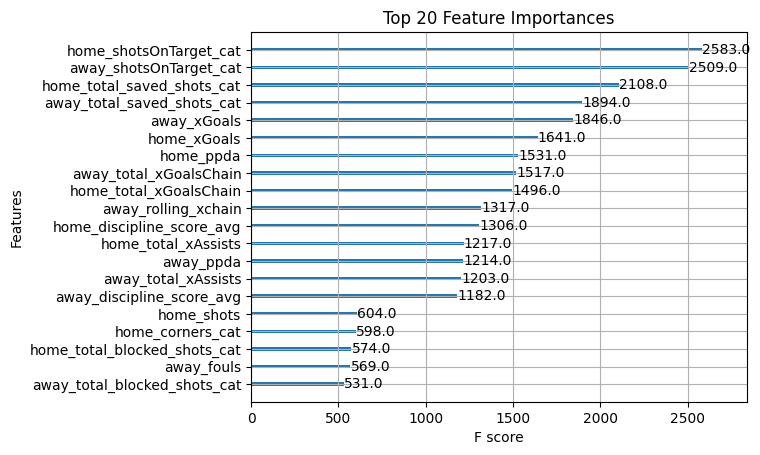

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=110, min_child_weight=50, n_estimators=100, subsample=0.8; total time=   9.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=60, min_child_weight=50, n_estimators=500, subsample=0.8; total time=  57.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=80, min_child_weight=50, n_estimators=900, subsample=0.8; total time= 1.6min
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=70, min_child_weight=50, n_estimators=600, subsample=0.8; total time= 1.1min
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=30, min_child_weight=50, n_estimators=600, subsample=0.8; total time= 1.1min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=40, min_child_weight=50, n_estimators=100, subsample=0.8; total time=  14.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=110, min_child_weight=50, n_estimators=700, subsample=0.8; total time= 1.3min
[CV] END colsample_bytree=1.0, lea

In [57]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(final_model, max_num_features=20)
plt.title("Top 20 Feature Importances")
plt.show()
